# Descripción del proyecto
A la cadena de supermercados **Good Seed** le gustaría explorar si la ciencia de los datos puede ayudarle a cumplir con las leyes sobre el alcohol, al asegurarse de no vender alcohol a personas menores de edad. Vamos a realizar esa evaluación, teniendo en cuenta lo siguiente:
- Las tiendas están equipadas con cámaras en el área de pago, las cuales se activan cuando una persona está comprando alcohol.
- Los métodos de visión artificial se pueden usar para determinar la edad de una persona a partir de una foto.
- La tarea, entonces, es construir y evaluar un modelo para verificar la edad de las personas.

Vamos a trabajar con un conjunto de fotografías de personas que indican su edad.

## Inicialización

In [14]:
# import libraries

#general
import pandas as pd
import numpy as np
import inspect
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
print(tf.__version__)

2.6.0


## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [4]:
# Path
path = 'datasets/faces/'

# reading "labels.csv"
data_labels = pd.read_csv(path+'labels.csv')

# reading photos from the folder "final_files" 

# normalize pixel values in the range 0 to 1, since the original pixel values are in the range 0 to 255.
datagen = ImageDataGenerator(rescale = 1/255)

# Takes the dataframe and the path to a images directory, and generates batches.
data_photos = datagen.flow_from_dataframe(
                        dataframe = data_labels,
                        directory = path+'final_files/',
                        x_col='file_name',
                        y_col='real_age',
                        target_size=(256, 256),
                        color_mode='rgb',
                        classes=None,
                        class_mode='raw',
                        batch_size=32,
                        shuffle=True,
                        seed=12345,
                        subset=None)

images, labels = next(data_photos)
print(f'\nShape: {images.shape}, {labels.shape}')
print('\nSample PHOTO')
print(f'\nAge: {labels[0]} and Pixels: \n{images[0]}')

Found 7591 validated image filenames.

Shape: (32, 256, 256, 3), (32,)

Sample PHOTO

Age: 50 and Pixels: 
[[[0.5764706  0.5137255  0.454902  ]
  [0.54509807 0.48235297 0.42352945]
  [0.5254902  0.46274513 0.4039216 ]
  ...
  [0.4901961  0.42352945 0.3137255 ]
  [0.49411768 0.427451   0.31764707]
  [0.49803925 0.43137258 0.32156864]]

 [[0.5372549  0.47450984 0.4156863 ]
  [0.50980395 0.44705886 0.38823533]
  [0.53333336 0.47058827 0.41176474]
  ...
  [0.48627454 0.41960788 0.30980393]
  [0.49803925 0.43137258 0.32156864]
  [0.50980395 0.4431373  0.33333334]]

 [[0.53333336 0.4666667  0.4039216 ]
  [0.5137255  0.44705886 0.38431376]
  [0.52156866 0.454902   0.3921569 ]
  ...
  [0.5137255  0.44705886 0.3372549 ]
  [0.5058824  0.43921572 0.32941177]
  [0.5058824  0.43921572 0.32941177]]

 ...

 [[0.07058824 0.46274513 0.5254902 ]
  [0.09411766 0.48627454 0.54901963]
  [0.07058824 0.45098042 0.5176471 ]
  ...
  [0.15686275 0.4039216  0.43137258]
  [0.14901961 0.39607847 0.42352945]
  [0.1

In [5]:
data_labels.sample(5)

,file_name,real_age
6117,006120.jpg,45
6645,006650.jpg,30
1218,001218.jpg,30
1913,001913.jpg,24
5108,005108.jpg,32


In [6]:
print(f'Shape {data_labels.shape}, duplicated {data_labels.duplicated().sum()}\n')
data_labels.info()

Shape (7591, 2), duplicated 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


- Hemos leido las fotos de rostros alojadas en la carpeta "final_files"; esta, cuenta con 7591 fotografías, y se normalizo los valores de píxeles en el rango de 0 a 1, ya que los valores de píxeles originales están en el rango de 0 a 255.  Se obtuvo 1 lote de 20 fotos, para poder explorar esta muestra de imágenes más adelante.

- Nuestro dataset "labels.csv" contiene 2 columnas, una con el nombre "file_name" correspondiente al nombre del archivo de la fotografía y otra llamada "real_age" con la edad de la persona. Además se verificó que no existen valores ausentes, ni registros duplicados. Los tipos de datos de cada columna están bien. La información de edad será nuestro "target" por lo que  ayudará a nuestro modelo a entrenarse.

## EDA

In [7]:
# Check "file_name": how many files there are with jpg extensions

print(f'Count photos jpg: {data_labels["file_name"].str.endswith(".jpg").sum()}')

Count photos jpg: 7591


In [8]:
# Check "real_age": descriptive statistics
print(f'{data_labels.describe()}')

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


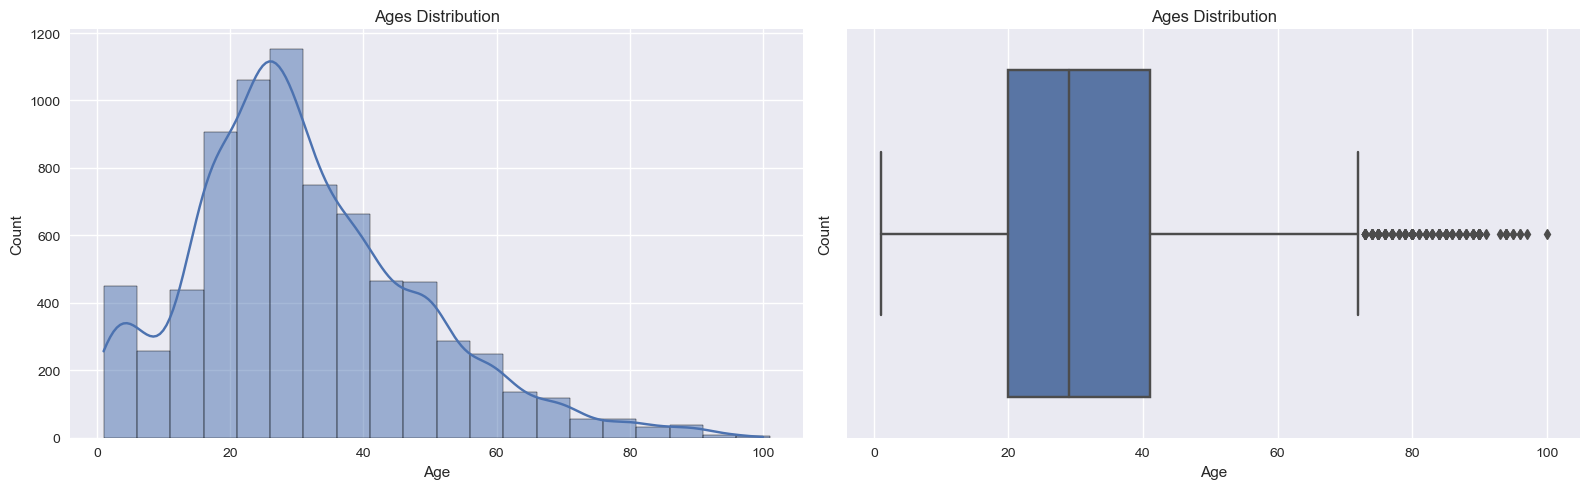

In [9]:
# Check ages distribution

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

a = ax[0]
sns.histplot(data_labels, x='real_age', binwidth=5, kde=True, ax=a)
a.set_xlabel('Age')
a.set_ylabel('Count')
a.set_title('Ages Distribution')

b = ax[1]
sns.boxplot(x=data_labels['real_age'], ax=b)
b.set_xlabel('Age')
b.set_ylabel('Count')
b.set_title('Ages Distribution')

fig.tight_layout();

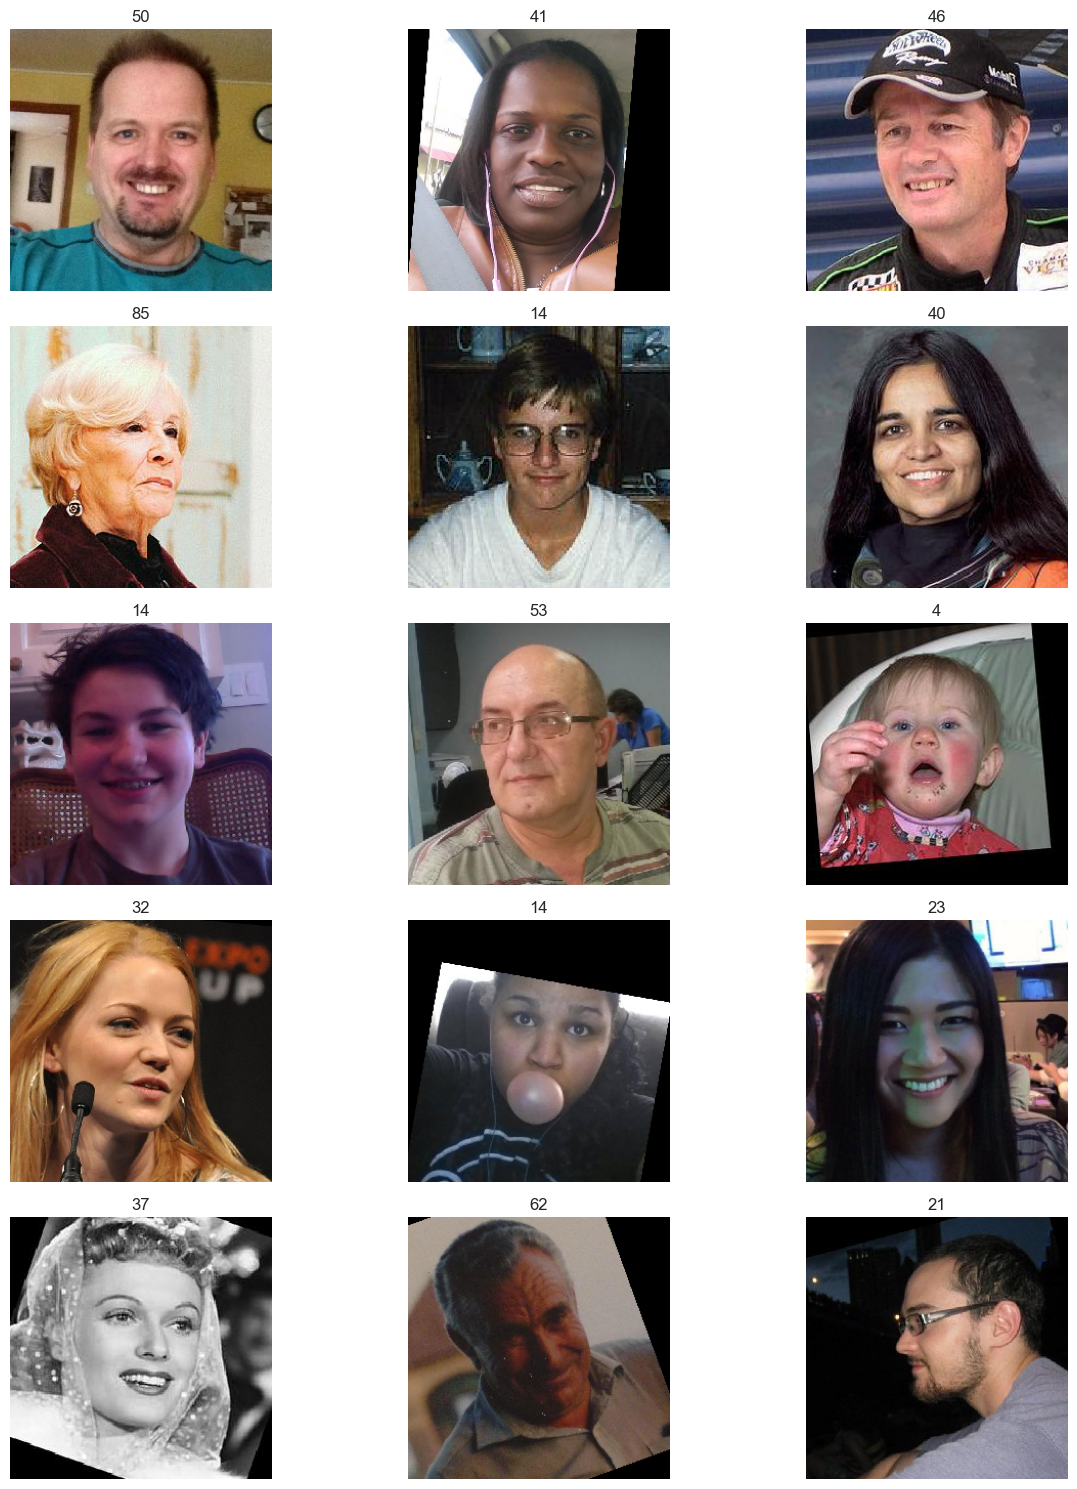

In [10]:
# Viewing photos
fig = plt.figure(figsize=(15,15))

for i in range(15):
    fig.add_subplot(5, 3, i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Conclusiones

Dataset **"labels.csv"**: 
- Guarda solo fotos con extensión jpg. Es decir todas las fotos se encuentran en formato jpg. 
- Las edades de las personas correspondiente en las fotos están en un rango de 1 a 100 años. La edad media es 31 años y la mediana de 29 años. Notando que existen fotografías con edades mayor a 70, considerandose de acuerdo a nuestra distribución edades atípicos.
- La mayor parte de las fotografías registradas están entre 20 a 30 años de edad con más de 2000 fotos. 

Folder **"final_files"**

Observamos en nuestro lote de 15 fotos un variado dataset de fotografías respecto a sus características. Observamos fotografias a color, en blanco y negro, personas de disntintas edades, de hombres y mujeres, fotografias en distintos planos, por ejemplo: retrato en primer plano,plano general, plano medio. Existen también variados fondos en cada fotografía, distintas iluminaciones que hacen fotografías más límpias en el rostro, así como fotografías con sombras o baja luz que pueden ser dificiles de leer.

## Modelado

Una vez que hemos realizado el análisis exploratorio de nuestro dataset e imágenes de personas. Vamos a construir nuestro modelo, para el cual crearemos 4 funciones necesarias para entrenar nuestro modelo predictivo de edades de personas basado en la lectura de su fotografia. Usaremos un procesamiento de imágenes usando redes neuronales artificiales entrenando nuestro modelo basado en una arquitectura "ResNet".

Necesitaremos las siguientes funciones:
- Para cargar nuestros datos para entrenamiento y para pruebas: "load_train", "load_test", 
- Para definir el modelo con sus capas: "create_model"
- Para entrenar el modelo: "train_model"

In [ ]:
def load_train(path):

    """
    the "load_train" function load the training dataset from path.
    path: directory where our dataset
    return iterator that generates batches of augmented/normalized data for training from the DataFrame.
    """

    # reading "labels.csv"
    data_labels = pd.read_csv(path+'labels.csv')

    datagen = ImageDataGenerator(rescale = 1/255, validation_split=0.25)
    
    train_gen_flow = datagen.flow_from_dataframe(dataframe = data_labels,
                                                 directory = path+'final_files/',
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 target_size=(256, 256),
                                                 color_mode='rgb',
                                                 classes=None,
                                                 class_mode='raw',
                                                 batch_size=32,
                                                 shuffle=True,
                                                 seed=12345,
                                                 subset='training')

    return train_gen_flow

In [ ]:
def load_test(path):

    """
    the "load_test" function load the validation dataset from path.
    path: directory where our dataset
    return iterator that generates batches of augmented/normalized data for training from the DataFrame.
    """

    # reading "labels.csv"
    data_labels = pd.read_csv(path+'labels.csv')

    datagen = ImageDataGenerator(rescale = 1/255, validation_split=0.25)
    
    test_gen_flow = datagen.flow_from_dataframe(dataframe = data_labels,
                                                 directory = path+'final_files/',
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 target_size=(256, 256),
                                                 color_mode='rgb',
                                                 classes=None,
                                                 class_mode='raw',
                                                 batch_size=32,
                                                 shuffle=True,
                                                 seed=12345,
                                                 subset='validation')

    return test_gen_flow

In [ ]:
def create_model(input_shape):

    """
    the "create_model" function to define the model
    input_shape: specify the form of input data to be sent to the first layer of a model in Keras. shape of images (224, 224, 3)
    return model
    """
      
    backbone = ResNet50(input_shape=input_shape, classes=1000, include_top=False, weights='imagenet') 

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(100, activation='relu'))   
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='relu'))   

    estimator= Adam(learning_rate=0.00001)
    model.compile(optimizer=estimator, loss='mean_squared_error', metrics=['mae'])

    return model


In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20, steps_per_epoch=None, validation_steps=None):

    """
    the "train_model" function trains the model
    parameters:
      "model", model defined
      "train_data", train dataset
      "test_data", validation dataset
      " batch_size= None", It will allow the model to support any batch size you can choose.
      "epochs=20", 20 times the model will go through the entire training data set during training.
      "steps_per_epoch",  number of steps (sample batches) before a training epoch is considered finished.
      "validation_steps", number of steps (sample batches) to validate before stopping.
    returns an already trained model

    """

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 

    model.fit(train_data, 
              validation_data=test_data, 
              batch_size=batch_size,  
              epochs=epochs, 
              steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, 
              verbose=2) 

    return model

### Script para ejecutarlo en la plataforma GPU

A continuación crearemos un script para la plataforma GPU el cual contiene nuestras funciones anteriores, y lo guardaremos con el nombre "run_model_on_gpu.py"

In [ ]:
# prepare a script to run on the GPU platform

init_str = """

import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# ---------------------------------------------------------------------------------

def load_train(path):

    # reading "labels.csv"
    data_labels = pd.read_csv(path+'labels.csv')

    datagen = ImageDataGenerator(rescale = 1/255, validation_split=0.25)
    
    train_gen_flow = datagen.flow_from_dataframe(dataframe = data_labels,
                                                 directory = path+'final_files/',
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 target_size=(256, 256),
                                                 color_mode='rgb',
                                                 classes=None,
                                                 class_mode='raw',
                                                 batch_size=32,
                                                 shuffle=True,
                                                 seed=12345,
                                                 subset='training')

    return train_gen_flow

# ---------------------------------------------------------------------------------

def load_test(path):

    # reading "labels.csv"
    data_labels = pd.read_csv(path+'labels.csv')

    datagen = ImageDataGenerator(rescale = 1/255, validation_split=0.25)
    
    test_gen_flow = datagen.flow_from_dataframe(dataframe = data_labels,
                                                 directory = path+'final_files/',
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 target_size=(256, 256),
                                                 color_mode='rgb',
                                                 classes=None,
                                                 class_mode='raw',
                                                 batch_size=32,
                                                 shuffle=True,
                                                 seed=12345,
                                                 subset='validation')

    return test_gen_flow
    
# ---------------------------------------------------------------------------------
   
def create_model(input_shape):
   
    backbone = ResNet50(input_shape=input_shape, classes=1000, include_top=False, weights='imagenet') 

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(100, activation='relu'))   
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='relu'))   

    estimator= Adam(learning_rate=0.00001)
    model.compile(optimizer=estimator, loss='mean_squared_error', metrics=['mae'])

    return model
    
# ---------------------------------------------------------------------------------

def train_model(model, train_data, test_data, batch_size=None, epochs=20, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 

    model.fit(train_data, 
              validation_data=test_data, 
              batch_size=batch_size,  
              epochs=epochs, 
              steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, 
              verbose=2) 

    return model


"""

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Análisis del modelo

**Construcción del modelo:**

El modelo fue construido basado en una instancia de la arquitectura "ResNet50" con pesos preentrenados en el conjunto de datos de *ImageNet* usándolo como columna vertebral del modelo. Luego, agregamos capas adicionales al modelo, incluyendo una capa de "GlobalAveragePooling2D", dos capas Dense con funciones de activación ‘relu’ y una capa de "Dropout". Finalmente, compila el modelo con el optimizador "Adam" y una tasa de aprendizaje de `0.00001`, utilizando la pérdida de "error cuadrático medio" y la métrica de "error absoluto medio". La función devuelve el modelo compilado.

*Explicación de la Red Neuronal Artificial por capa:*
- `backbone` Crea una instancia de la arquitectura `ResNet50` con pesos preentrenados en el conjunto de datos de ImageNet y la usa como columna vertebral del modelo.
- `model = Sequential()` crea una instancia de un modelo secuencial de Keras. Un modelo secuencial es un tipo de modelo de aprendizaje profundo en el que las capas se apilan una encima de la otra en secuencia.
- `model.add(backbone)` agrega la columna vertebral del modelo, que en este caso es una instancia de la arquitectura "ResNet50" con pesos preentrenados en el conjunto de datos de ImageNet, a la parte superior del modelo secuencial.
- `model.add(GlobalAveragePooling2D())` Esta capa aplica un promedio global de agrupación en el eje espacial (ancho y alto) de los datos de entrada. Esto reduce la dimensión espacial de los datos a 1, lo que significa que para cada canal de características en los datos de entrada, la capa calcula el promedio de todos los valores en ese canal y devuelve un solo valor promedio.
- `model.add(Dense(100, activation='relu'))` con 100 neuronas y una función de activación ‘relu’ al modelo.
- `model.add(Dropout(0.25))` Agrega una capa Dropout con una tasa de 0.25 al modelo para reducir el sobreajuste.
- `model.add(Dense(1, activation='relu'))` agrega otra capa Dense con 1 neurona y una función de activación ‘relu’ al modelo.

Las capas "Dense" son capas completamente conectadas en las que cada neurona está conectada a todas las neuronas de la capa anterior. Estas capas realizan una transformación lineal de los datos de entrada seguida de una función de activación no lineal.

La capa "Dropout" es una técnica de regularización utilizada para reducir el sobreajuste en redes neuronales. Durante el entrenamiento, esta capa “desactiva” aleatoriamente un subconjunto de neuronas en la capa anterior, lo que significa que no contribuyen a la propagación hacia adelante ni a la retropropagación. Esto obliga a la red a aprender representaciones más robustas de los datos al evitar que las neuronas dependan demasiado unas de otras. 

**Entrenamiento del modelo**

- Para el entrenamiento la función toma como entrada un modelo de Keras, datos de entrenamiento y prueba, y varios parámetros opcionales como batch_size, epochs, steps_per_epoch y validation_steps. 
- La función entrena el modelo en los datos de entrenamiento utilizando el método fit del modelo. 
- Si steps_per_epoch y validation_steps no se especifican, se establecen en la longitud de los datos de entrenamiento y prueba, respectivamente. 
- El método fit entrena el modelo durante un número especificado de épocas, en este caso 20 épocas, utilizando el tamaño de lote especificado y los pasos por época y los pasos de validación. La función devuelve el modelo entrenado.

### Resultados

Mostramos a continuación los resultados obtenidos del entrenamiento de nuestro modelo de red neuronal:

```python
Train for 178 steps, validate for 60 steps
Epoch 1/20
178/178 - 46s - loss: 755.0082 - mae: 22.5125 - val_loss: 1116.9815 - val_mae: 28.9149
Epoch 2/20
178/178 - 40s - loss: 145.4469 - mae: 9.0915 - val_loss: 1069.8759 - val_mae: 28.1330
Epoch 3/20
178/178 - 41s - loss: 66.7468 - mae: 6.3549 - val_loss: 890.9831 - val_mae: 25.1535
Epoch 4/20
178/178 - 41s - loss: 45.3248 - mae: 5.2678 - val_loss: 216.8288 - val_mae: 10.9162
Epoch 5/20
178/178 - 41s - loss: 36.7908 - mae: 4.6650 - val_loss: 110.1322 - val_mae: 8.0652
Epoch 6/20
178/178 - 42s - loss: 34.0132 - mae: 4.3770 - val_loss: 89.6076 - val_mae: 7.2595
Epoch 7/20
178/178 - 42s - loss: 30.2367 - mae: 4.1760 - val_loss: 86.5554 - val_mae: 7.0678
Epoch 8/20
178/178 - 41s - loss: 28.7507 - mae: 4.0509 - val_loss: 85.0061 - val_mae: 6.9847
Epoch 9/20
178/178 - 42s - loss: 26.7662 - mae: 3.8873 - val_loss: 85.1740 - val_mae: 6.9411
Epoch 10/20
178/178 - 41s - loss: 25.3011 - mae: 3.7957 - val_loss: 85.1825 - val_mae: 6.9574
Epoch 11/20
178/178 - 42s - loss: 24.7509 - mae: 3.7659 - val_loss: 87.0973 - val_mae: 6.9831
Epoch 12/20
178/178 - 41s - loss: 24.9382 - mae: 3.7595 - val_loss: 84.5608 - val_mae: 6.9829
Epoch 13/20
178/178 - 42s - loss: 22.5064 - mae: 3.5956 - val_loss: 97.1299 - val_mae: 7.3852
Epoch 14/20
178/178 - 41s - loss: 22.6958 - mae: 3.6025 - val_loss: 83.7944 - val_mae: 6.9057
Epoch 15/20
178/178 - 41s - loss: 21.5392 - mae: 3.4860 - val_loss: 86.5438 - val_mae: 6.9887
Epoch 16/20
178/178 - 41s - loss: 20.2800 - mae: 3.3884 - val_loss: 83.5644 - val_mae: 6.9161
Epoch 17/20
178/178 - 41s - loss: 19.5347 - mae: 3.3267 - val_loss: 81.2918 - val_mae: 6.8345
Epoch 18/20
178/178 - 41s - loss: 18.1645 - mae: 3.1858 - val_loss: 80.6219 - val_mae: 6.7939
Epoch 19/20
178/178 - 41s - loss: 17.7798 - mae: 3.1517 - val_loss: 80.8236 - val_mae: 6.7978
Epoch 20/20
178/178 - 41s - loss: 16.9592 - mae: 3.0751 - val_loss: 80.4912 - val_mae: 6.8234
```

Este resultado muestra el progreso del entrenamiento de una red neuronal para predecir la edad de las personas a partir de sus fotos. El modelo se entrena durante 20 épocas, con 178 pasos por época en el conjunto de entrenamiento y 60 pasos en el conjunto de validación. En cada época, se muestra la pérdida mediante el mean_squared_error (MSE) y la métrica de evaluación del modelo con el error absoluto medio (MAE) en el conjunto de entrenamiento y validación.

Podemos ver que MSE y MAE en el conjunto de entrenamiento disminuyen constantemente a medida que avanzan las épocas, lo que indica que el modelo está aprendiendo a predecir mejor la edad a partir de las fotos en el conjunto de entrenamiento. 

El MSE y el MAE en el conjunto de validación también disminuyen durante las primeras épocas, pero luego se estabilizan alrededor de la época 8. Esto sugiere que el modelo está generalizando bien a los datos no vistos en el conjunto de validación.

En la última época, el MAE en el conjunto de entrenamiento es 3.0751 años, lo que significa que en promedio, las predicciones del modelo están a 3.0751 años de la edad real en el conjunto de entrenamiento. En el conjunto de validación, el MAE es 6.8234 años, lo que significa que en promedio, las predicciones del modelo están a 6.8234 años de la edad real en el conjunto de validación.


No parece haber un sobreajuste significativo en los resultados. El sobreajuste ocurre cuando el modelo se ajusta demasiado a los datos de entrenamiento y no generaliza bien a los datos no vistos. Una señal de sobreajuste es cuando la pérdida y el error en el conjunto de entrenamiento continúan disminuyendo, pero la pérdida y el error en el conjunto de validación comienzan a aumentar.

En este caso, podemos ver que tanto la pérdida como el MAE en el conjunto de validación disminuyen durante las primeras épocas y luego se estabilizan. Esto sugiere que el modelo está generalizando bien a los datos no vistos en el conjunto de validación y no hay un sobreajuste significativo.

## Conclusiones

#### ¿Puede la visión artificial ayudar al cliente en este caso?
Sí, la visión artificial puede ayudar al cliente en este caso. Los resultados que obtuvimos de nuestro modelo muestran que se ha entrenado una red neuronal para predecir la edad de las personas a partir de sus fotos utilizando técnicas de visión artificial. El modelo parece generalizar bien a los datos no vistos en el conjunto de validación y puede proporcionar predicciones razonablemente precisas de la edad a partir de las fotos.

Para implementar nuestro modelo predictivo, necesitamos que las tiendas estén equipadas con cámaras en el área de pago, las cuales se activan cuando una persona está comprando alcohol, pudiendo obtener una foto del rostro del cliente, la cual evaluaremos la edad con nuestro modelo.



#### ¿Qué otras tareas prácticas podría resolver el cliente con el modelo? Comparte tus ideas al respecto.
Hay muchas tareas prácticas que el cliente podría resolver con un modelo de visión artificial que predice la edad a partir de fotos. Algunas ideas podrían incluir:

- **Verificación de edad**: El modelo podría utilizarse para verificar la edad de las personas en línea, por ejemplo, para restringir el acceso a contenido solo para adultos o para cumplir con las regulaciones de edad en ciertas transacciones en línea.

- **Personalización del contenido**: El modelo podría utilizarse para personalizar el contenido que se muestra a los usuarios en función de su edad. Por ejemplo, un sitio web de comercio electrónico podría mostrar diferentes productos o promociones a los usuarios según su edad.

- **Análisis demográfico**: El modelo podría utilizarse para analizar las características demográficas de un grupo de personas a partir de sus fotos. Por ejemplo, una empresa podría utilizar el modelo para estimar la edad promedio de las personas que visitan una tienda o asisten a un evento.

- **Investigación de mercado**: El modelo podría utilizarse para realizar investigaciones de mercado y comprender mejor las preferencias y comportamientos de diferentes grupos de edad.

- **Seguridad y vigilancia**: El modelo podría utilizarse en sistemas de seguridad y vigilancia para detectar personas menores de edad en áreas restringidas o para identificar a personas mayores que puedan necesitar asistencia.

Estas son solo algunas ideas y hay muchas otras aplicaciones posibles. Sin embargo, es importante tener en cuenta que siempre habrá cierto grado de error en las predicciones del modelo y que es importante considerar cuestiones éticas y legales al utilizar modelos de visión artificial para tomar decisiones que afecten a las personas.
